In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, RocCurveDisplay

Take a look at data

In [2]:
data = pd.read_csv('promoter_seq.csv', index_col=[0])
data

,class,name,sequence
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
...,...,...,...
101,-,799,cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...
102,-,987,gtattctcaacaagattaaccgacagattcaatctcgtggatggac...
103,-,1226,cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...
104,-,794,ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...


In [3]:
data = data.drop('name', axis=1)
print('Classes. + if promoter, - if non-promoter')
print(data['class'].value_counts())
data.info()

Classes. + if promoter, - if non-promoter
+    53
-    53
Name: class, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     106 non-null    object
 1   sequence  106 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


Prepare data for model

In [4]:
def makekmer(sequence, size):
    # make list of k-mers of length 'size' from sequence
    kmers = [sequence[x:x+size] for x in range(len(sequence) - size + 1)]
    # join k-mers into sentence
    kmers = ' '.join(kmers)
    return kmers

In [5]:
# convert sequences into 'sentences' of k-mers
data['seqlen'] = data['sequence'].apply(len)
data['kmers'] = data['sequence'].apply(lambda x: makekmer(x, size=5))
# label encode class
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])
print('classes: ',le.classes_)
data

classes:  ['+' '-']


,class,sequence,seqlen,kmers
0,0,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,57,tacta actag ctagc tagca agcaa gcaat caata aata...
1,0,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,57,tgcta gctat ctatc tatcc atcct tcctg cctga ctga...
2,0,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,57,gtact tacta actag ctaga tagag agaga gagaa agaa...
3,0,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,57,aattg attgt ttgtg tgtga gtgat tgatg gatgt atgt...
4,0,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,57,tcgat cgata gataa ataat taatt aatta attaa ttaa...
...,...,...,...,...
101,1,cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...,57,cctca ctcaa tcaat caatg aatgg atggc tggcc ggcc...
102,1,gtattctcaacaagattaaccgacagattcaatctcgtggatggac...,57,gtatt tattc attct ttctc tctca ctcaa tcaac caac...
103,1,cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...,57,cgcga gcgac cgact gacta actac ctacg tacga acga...
104,1,ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...,57,ctcgt tcgtc cgtcc gtcct tcctc cctca ctcaa tcaa...


In [6]:
# split data into train and test sets
trainx, testx, trainy, testy = train_test_split(data['kmers'], data['class'], \
                                                test_size=0.25, random_state=567, stratify=data['class'])
trainy.value_counts()

1    40
0    39
Name: class, dtype: int64

In [7]:
trainx

58     gccaa ccaat caatc aatca atcaa tcaat caatc aatc...
103    cgcga gcgac cgact gacta actac ctacg tacga acga...
19     gcaaa caaat aaata aataa ataat taatc aatca atca...
15     aagca agcaa gcaaa caaag aaaga aagaa agaaa gaaa...
27     tccag ccagt cagta agtat gtata tataa ataat taat...
                             ...                        
74     catga atgaa tgaac gaact aactc actca ctcaa tcaa...
36     tcgtt cgttg gttgt ttgta tgtat gtata tatat atat...
65     aactc actca ctcaa tcaag caagg aaggc aggct ggct...
45     cacta actaa ctaat taatt aattt attta tttat ttat...
42     ttagc tagcg agcgg gcgga cggat ggatc gatcc atcc...
Name: kmers, Length: 79, dtype: object

In [8]:
# create 'bag of words' from k-mers
# features of single 5-mers and paired 5-mers 
vect = CountVectorizer(ngram_range=(1,2))
bagofwords = vect.fit_transform(trainx)
# (# samples, # total k-mers)
print(bagofwords.shape)
# frequency of k-mer occurance in train set
pd.Series(bagofwords.toarray().sum(axis=0)).value_counts()

(79, 2981)


1     1131
2      645
3      407
4      282
5      194
6      100
7       83
8       49
9       29
10      21
11      15
12       9
14       7
15       3
13       3
20       2
16       1
dtype: int64

Model

In [9]:
# generate model
# naive bayes

score=[]

# split training data into folds
skf = StratifiedKFold(n_splits=5)
for trainidx, validx in skf.split(trainx,trainy):
    Xtrain, ytrain = trainx.iloc[trainidx], trainy.iloc[trainidx]
    Xval, yval = trainx.iloc[validx], trainy.iloc[validx]
    
    # create bag of words from train fold
    vect = CountVectorizer(ngram_range=(1,2))
    Xtrain = vect.fit_transform(Xtrain)
    
    Xval = vect.transform(Xval)
    
    # fit classifier
    clf = BernoulliNB()
    clf.fit(Xtrain, ytrain)
    
    # store score on validation set
    score.append(clf.score(Xval, yval))
    
print('Accuracy Scores: ', score)
print('Mean Accuracy', np.mean(score))


Accuracy Scores:  [0.8125, 0.875, 0.875, 0.875, 1.0]
Mean Accuracy 0.8875


In [10]:
# apply model to test set
# naive bayes

# create bag of words from train fold
vect = CountVectorizer(ngram_range=(1,2))
trainbow = vect.fit_transform(trainx)

testbow = vect.transform(testx)

# fit classifier
clf = BernoulliNB()
clf.fit(trainbow, trainy)

# store score on validation set
ypred = clf.predict(testbow)

# store probability estimates
yprob = clf.predict_proba(testbow)

print('Accuracy: ', clf.score(testbow, testy))

Accuracy:  0.9629629629629629


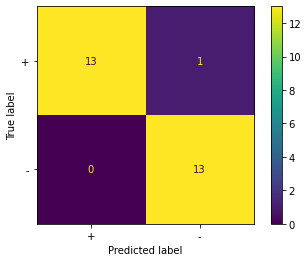

In [11]:
ConfusionMatrixDisplay.from_predictions(testy, ypred, display_labels=['+','-'])

In [12]:
# misclassified 1 promoter
precision, recall, fscore, support = precision_recall_fscore_support(testy, ypred)
print('Precision: ', precision)
print('Recall: ', recall)

Precision:  [1.         0.92857143]
Recall:  [0.92857143 1.        ]


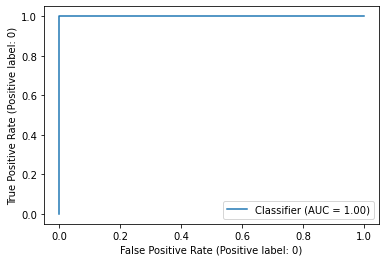

In [13]:
# naive bayes ROC 
# using probability estimates of positive class (probability of being a promoter)
RocCurveDisplay.from_predictions(testy, yprob[:,0], pos_label=0)

In [14]:
# generate model
# logistic regression, l2

score=[]

# split training data into folds
skf = StratifiedKFold(n_splits=5)
for trainidx, validx in skf.split(trainx,trainy):
    Xtrain, ytrain = trainx.iloc[trainidx], trainy.iloc[trainidx]
    Xval, yval = trainx.iloc[validx], trainy.iloc[validx]
    
    # create bag of words from train fold
    vect = CountVectorizer(ngram_range=(1,2))
    Xtrain = vect.fit_transform(Xtrain)
    
    Xval = vect.transform(Xval)
    
    # fit classifier
    clf = LogisticRegression(solver='liblinear', penalty='l2')
    clf.fit(Xtrain, ytrain)
    
    # store score on validation set
    score.append(clf.score(Xval, yval))
    
print('Accuracy Scores: ', score)
print('Mean Accuracy', np.mean(score))


Accuracy Scores:  [0.875, 0.875, 0.875, 0.875, 1.0]
Mean Accuracy 0.9


In [15]:
# apply model to test set
# logistic regression

# create bag of words from train fold
vect = CountVectorizer(ngram_range=(1,2))
trainbow = vect.fit_transform(trainx)

testbow = vect.transform(testx)

# fit classifier
clf = LogisticRegression(solver='liblinear', penalty='l2')
clf.fit(trainbow, trainy)

# store score on validation set
ypred = clf.predict(testbow)

# store probability estimates
yprob = clf.predict_proba(testbow)

print('Accuracy: ', clf.score(testbow, testy))

Accuracy:  1.0


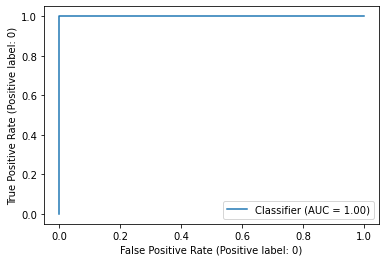

In [16]:
# logistic regression ROC 
# using probability estimates of positive class (probability of being a promoter)
#fpr, tpr, thresholds = roc_curve(testy, yprob[:,0], pos_label=0)
#plt.plot(fpr, tpr)   
RocCurveDisplay.from_predictions(testy, yprob[:,0], pos_label=0)